In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
db = 'chinook.db'

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [3]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [4]:
def show_tables():
    q = '''
    
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [5]:
test_q = '''
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    WHERE c.country = "USA"
'''

run_query(test_q)

,invoice_line_id,invoice_id,track_id,unit_price,quantity
0,1,1,1158,0.99,1
1,2,1,1159,0.99,1
2,3,1,1160,0.99,1
3,4,1,1161,0.99,1
4,5,1,1162,0.99,1
5,6,1,1163,0.99,1
6,7,1,1164,0.99,1
7,8,1,1165,0.99,1
8,9,1,1166,0.99,1
9,10,1,1167,0.99,1


In [6]:
album_purchase_q = '''
    WITH usa_tracks_sold AS
        (
         SELECT il.* FROM invoice_line il
         INNER JOIN invoice i ON i.invoice_id = il.invoice_id
         INNER JOIN customer c ON c.customer_id = i.customer_id
         WHERE c.country = "USA"
         )
         
SELECT
    g.name genre,
    COUNT(uts.invoice_line_id) tracks_sold,
    CAST(COUNT(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) FROM usa_tracks_sold) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t ON t.track_id = uts.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;'''

run_query(album_purchase_q)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


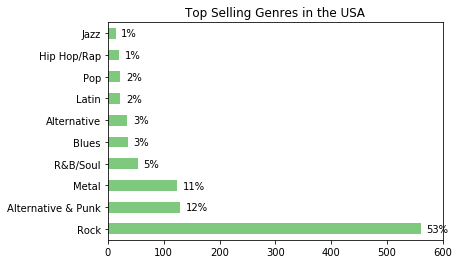

In [7]:
usa_genre_sales = run_query(album_purchase_q)
usa_genre_sales.set_index("genre", inplace=True, drop=True)

usa_genre_sales["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0,600),
    colormap=plt.cm.Accent)

plt.ylabel('')

for i, label in enumerate(list(usa_genre_sales.index)):
    score = usa_genre_sales.loc[label, "tracks_sold"]
    label = (usa_genre_sales.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.savefig("top_sellers.png")
plt.show()    

Based on our findings, we should purchase new albums by the following artists:
- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)

In [8]:
test_q2 = '''
    SELECT
        c.support_rep_id,
        i.customer_id,
        SUM(i.total) total_sales
        FROM invoice i
        INNER JOIN customer c ON c.customer_id = i.customer_id
        GROUP BY c.support_rep_id, i.customer_id;
'''

run_query(test_q2)

,support_rep_id,customer_id,total_sales
0,3,1,108.90
1,3,3,99.99
2,3,12,82.17
3,3,15,66.33
4,3,18,79.20
5,3,19,54.45
6,3,24,71.28
7,3,29,40.59
8,3,30,91.08
9,3,33,75.24


In [9]:
support_rep_sales = '''
    WITH support_rep_sales AS
    (
        SELECT
            c.support_rep_id,
            i.customer_id,
            SUM(i.total) total
        FROM invoice i
        INNER JOIN customer c ON c.customer_id = i.customer_id
        GROUP BY c.support_rep_id, i.customer_id
    )
    
SELECT
    e.first_name || " " || e.last_name employee_name,
    e.hire_date,
    SUM(srs.total) rep_total
    FROM employee e
    INNER JOIN support_rep_sales srs ON e.employee_id = srs.support_rep_id
    GROUP BY employee_name;
'''

run_query(support_rep_sales)

,employee_name,hire_date,rep_total
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


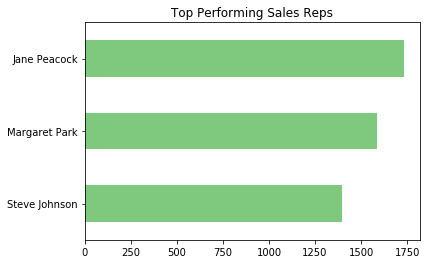

In [10]:
support_sales = run_query(support_rep_sales)

support_sales.set_index("employee_name", inplace=True, drop=True)
support_sales.sort_values("rep_total", inplace=True)
support_sales["rep_total"].plot.barh(
    title="Top Performing Sales Reps",
    legend=False,
    colormap=plt.cm.Accent)

plt.ylabel('')

plt.savefig("top_sales_reps.png")
plt.show()  

There's a greater than 15% difference between the top and bottom employees, Jane and Steve respectively, but the difference may be related to the time they were hired.

In [11]:
test_q3 = '''
    SELECT
        c.country,
        COUNT(*) total_customers,
        SUM(i.total) total_sales,
        AVG(i.total) / SUM(i.customer_id) sales_per_customer,
        AVG(i.total) avg_value
    FROM invoice i
    INNER JOIN customer c ON i.customer_id = c.customer_id
    GROUP BY c.country
    ORDER BY total_sales DESC;
'''

run_query(test_q3)

,country,total_customers,total_sales,sales_per_customer,avg_value
0,USA,131,1040.49,0.002749,7.942672
1,Canada,76,535.59,0.003913,7.047237
2,Brazil,61,427.68,0.012300,7.011148
3,France,50,389.07,0.003781,7.781400
4,Germany,41,334.62,0.007223,8.161463
5,Czech Republic,30,273.24,0.056222,9.108000
6,United Kingdom,28,245.52,0.005905,8.768571
7,Portugal,29,185.13,0.006371,6.383793
8,India,21,183.15,0.007114,8.721429
9,Ireland,13,114.84,0.014772,8.833846


In [12]:
test_q4 = '''
    SELECT
        CASE
            WHEN
                (
                 SELECT COUNT(*)
                 FROM customer
                 WHERE country = c.country
                 ) = 1 THEN "Other"
            ELSE c.country
        END AS country,
        c.customer_id,
        il.*
    FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN  customer c ON c.customer_id = i.customer_id
'''

run_query(test_q4)

,country,customer_id,invoice_line_id,invoice_id,track_id,unit_price,quantity
0,USA,18,1,1,1158,0.99,1
1,USA,18,2,1,1159,0.99,1
2,USA,18,3,1,1160,0.99,1
3,USA,18,4,1,1161,0.99,1
4,USA,18,5,1,1162,0.99,1
5,USA,18,6,1,1163,0.99,1
6,USA,18,7,1,1164,0.99,1
7,USA,18,8,1,1165,0.99,1
8,USA,18,9,1,1166,0.99,1
9,USA,18,10,1,1167,0.99,1


In [13]:
country_sales = '''
WITH country_other AS
    (
     SELECT
         CASE
             WHEN (
                 SELECT COUNT(*)
                 FROM customer
                 WHERE country = c.country
                  ) = 1 THEN "Other"
             ELSE c.country
         END AS country,
         c.customer_id,
         il.*
    FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN  customer c ON c.customer_id = i.customer_id
    )
    
SELECT
    country,
    customers,
    total_sales,
    ltv,
    avg_val
FROM
    (
    SELECT
        country,
        COUNT(DISTINCT customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / COUNT(DISTINCT customer_id) ltv,
        SUM(unit_price) / COUNT(DISTINCT invoice_id) avg_val,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(country_sales)

,country,customers,total_sales,ltv,avg_val
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


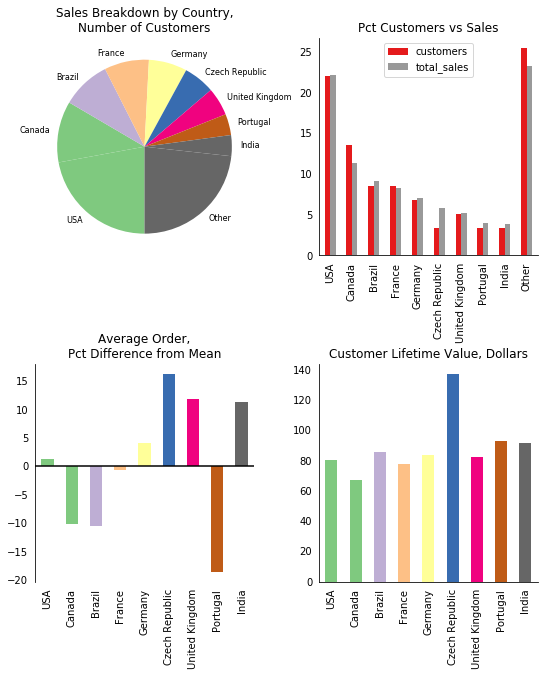

In [14]:
country_metrics = run_query(country_sales)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["avg_val"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["ltv"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.savefig("country_sales_metrics.png")
plt.show()

Based on the data, there are opportunities we can explore in the following countries:

- Czech Republic
- United Kingdom
- India

Keep in mind, however, that the sample size is small and we should avoid overcommitting to these countries. It would be wise to run smaller campaigns in these countries and to analyze our data again once we receive a large enough sample to draw conclusions from

In [15]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Album purchases account for nearly 20% of purchases. Based on that, I would not recommend buying tracks from albums from record companies.